# Distribuições Territoriais

Esta seção constrói mapas básicos das áreas de estudo: as cidades de Belo Horizonte, Rio de Janeiro e São Paulo. Especificamente, serão consolidadas e apresentadas as distribuições territoriais de variáveis demográficas e socioeconômicas de interesse. Adicionalmente, há o complemento de atributos territoriais que entende-se que são, também, variáveis explicativas. Especificamente, o foco estará, preliminarmente, nas seguintes variáveis, as quais serão elaboradas em maior profundidade mais à frente.

- Contagens populacionais
- Rendimentos médios
- Contagens de postos de trabalho
- Índice de bem estar urbano
- Medidas geométricas e topológicas da malha de vias caminháveis

Os itens que seguem tratam de detalhar os passos metodológicos utilizados, o embasamento teórico-conceitual (ou empírico) que é subjacente a esses passos, bem como as fontes de dados. Ainda, logo de início estão listadas as bibliotecas em Python que dão suporte a todo o processo. Maiores detalhes a respeito do funcionamento dessas bibliotecas são dados na medida do necessário. 

Os dados consolidados serão apresentados em formato de mapas (estáticos) e salvos para uso nas etapas posteriores do artigo. Análises espaciais e estat;isticas mais aprofundadas serão conteúdo de scripts mais à frente. De particular interesse será verificar a articulação entre as porções do território de cada cidade, uma vez que esses fluxos sejam confrontados com os fluxos e as infraestruturas de transporte motorizado.

# Procedimentos Preliminares

## Bibliotecas

In [1]:
import pathlib

import contextily as ctx
import basedosdados as bd
import geobr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.affinity import scale
from statsmodels.stats.weightstats import DescrStatsW
from getpass import getpass
from tobler.area_weighted import area_interpolate
from tobler.util import h3fy



Cannot find header.dxf (GDAL_DATA is not defined)


## Parâmetros de Base

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
gcloud_id = getpass('Google Cloud Services billing ID:')

In [5]:
# Forneça código do IBGE da cidade, ou lista de códigos
# se quiser cidades vizinhas. P. ex.:
# ibge_id = 3106200 -> Belo Horizonte
ibge_id = [3303302, 3304904, 3301900] # -> Niteroi e Sao Goncalo e Itaboraí

# Das Malhas Territorias

A malha hexagonal H3 será utilizada como recorte espacial principal ao longo das análises†. Recortes hexagonais apresentam vantagens importantes frente a outras geometrias, sobretudo, eles podem reduzir vieses amostrais derivados de efeitos de borda e, adicionalmente, são mais mais adequados do que malhas retangulares para analisar fenômenos em que relações de vizinhança e conectividade são importantes (Birch, Oom, & Beecham, 2007). Essas vantagens da malha hexagonal serão mais imporantes quando estiverem sendo executadas as análises de acessibilidade, mas, até lá, também foi mostrado por Birch et al. (2007) que hexágonos favorecem a visualização de padrões e mitigam, em alguma medida, efeitos de borda.

Esses efeitos de borda, simplificadamente, dizem respeito a erros de representação na variação local dos dados. Isto é, outras geometrias — malhas quadriculadas, p. ex. — são mais propensas a apresentar variações bruscas e artificiais entre vizinhos — uma quadrícula com valores muito altos ladeada por quadrículas com valores muito baixos. Isso prejudica a análise e a visualização, assim favorecendo erros de interpretação.

Dados socioeconômicos e demográficos, por sua vez, serão imputados em cada hexágono a partir do enso demográfico de 2010. Esses dados censitários serão requisitados ao datalake público da Base dos Dados‡, enquanto que as malhas desses setores serão obtidas junto à biblioteca geobr⨥. Assim, de posse das malhas do IBGE e dos respectivos dados, procedimentos de interpolação espacial⁙ farão a transferência dos dados do censo para os hexágonos.

Complementarmente, para além das informações dos setores censitários, a grade estatística⁜ também será utilizada como insumo, a qual apresenta contagens populacionais com uma resolução maior que a dos agregados por setor: há uma malha com resolução de 200x200 m em áreas urbanas e de 1x1 km em áreas rurais. A grade é importante porque remove as áreas inabitadas — a Floresta d Tijuca, no Rio de Janeiro, p. ex. — e porque permitem localizar o centroide dos hexágonos de maneira mais precisa: seguindo recomendação de Stępniak and Jacobs-Crisioni (2017), o centro de cada geometria deve ser ponderado pela distribuição populacional nela contida, a fim de que haja uma representação mais precisa dos tempos de viagem entre geometrias.

Resta definir qual a resolução dessas malha. Conforme demonstrado, por exemplo, em Pereira et al. (2019), é importante avaliar distintos tamanhos de geometria, a fim de verificar se os resultados obtidos são realmente robustos ou se não passam de artefatos computacionais. Mas, quais resoluções⁕? A menor escala na qual ainda há dados disponíveis é a grade estatística, de maneira que hexágonos menores que ela não agregariam nenhum valor à análise, ao mesmo tempo em que elevariam, desnecessariamente, o tempo de processamento computacional. Com efeito, a menor resolução utilizada é a 9, com área relativamente próxima a um quadrado de lado 200m. No outro extremo, resta definir a maior resolução utilizada. A maior delas será a 7, com área de aproximadamente 5 km2. Tamahos maiores agregariam grandes regiões muito distintas entre si, contribuindo em demasiado para uma ilusão de homogeneidade a qual não existe — p. ex., a resolução 6 já conta com área de cercade 35km2. Portanto, serão avaliadas as resoluções 7, 8 e 9.

    Birch, C. P., Oom, S. P., & Beecham, J. A. (2007). Rectangular and hexagonal grids used for observation, experiment and simulation in ecology. Ecological modelling, 206(3-4), 347-359.
    
    Pereira, R. H., Banister, D., Schwanen, T., & Wessel, N. (2019). Distributional effects of transport policies on inequalities in access to opportunities in Rio de Janeiro. Journal of Transport and Land Use, 12(1), 741-764.
    
    Stępniak, M., & Jacobs-Crisioni, C. (2017). Reducing the uncertainty induced by spatial aggregation in accessibility and spatial interaction applications. Journal of Transport Geography, 61, 17-29.

    † Especificamente, será feito uso das bibliotecas em Python implementadas pela Uber (https://h3geo.org/), baseadas no sistema proposto em:

        Sahr, K., White, D., & Kimerling, A. J. (2003). Geodesic discrete global grid systems. Cartography and Geographic Information Science, 30(2), 121-134.
        
    ‡ ver https://basedosdados.org/

    ⨥ ver https://github.com/ipeaGIT/geobr
    
    ⁙ https://github.com/pysal/tobler

    ⁜ obtida diretamente do site do IBGE em https://censo2010.ibge.gov.br/component/saladeimprensa/?busca=1&id=3&idnoticia=3123&t=grade-estatistica-permite-obter-dados-censo-2010-diversos-recortes-espaciais&view=noticia
    
    ⁕ ver https://h3geo.org/docs/core-library/restable para uma lista de resoluções e as respectivas dimensões

## Malhas Censitárias

In [6]:
def get_study_area(ibge_id):
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    return pd.concat([
        geobr.read_census_tract(id_)
        for id_
        in ibge_id
        ])


tracts = get_study_area(ibge_id)

In [7]:
crs = tracts.estimate_utm_crs(datum_name='SIRGAS 2000')
crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
tracts = tracts.to_crs(crs)

Abaixo, utiliza-se a função h3fy, cuja documentação pode ser encontrada [aqui](https://pysal.org/tobler/generated/tobler.util.h3fy.html).

In [9]:
hexes = h3fy(tracts, resolution=9)

# A Leitura dos Atributos Territoriais

Resgatando o que foi dito no preâmbulo deste script, estamos interessados nas seguintes variáveis:
1. Contagens populacionais
2. Contagem de domicílios
3. Rendimentos médios
4. Contagens de postos de trabalho
5. Índice de bem estar urbano

A ideia, portanto, é fazer a leitura e o ajuste dessas variáveis para que possam ser imptuadas nas malhas hexagonais H3.

## Rendimentos Médios

Os rendimentos serão obtidos a partir da API da Base dos Dados. Especificamente, utiliza-se a seguinte variável da tabela básica do Censo de 2010:

- v009: Valor do rendimento nominal médio mensal das pessoas de 10 anos ou mais de idade (com e sem rendimento)

In [10]:
def _sql_style_list(sequence):
    single_quoted_elements = [f"'{c}'" for c in sequence]
    return ', '.join(single_quoted_elements)

In [11]:
def read_census_data(query, gcloud_id):
    data = bd.read_sql(query,
                       billing_project_id=gcloud_id)
    
    return (
        data.astype({'id_setor_censitario': np.int64})
            .astype({'id_setor_censitario': str})
            .rename(
                columns={
                    'v009': 'rendimento_medio',
                    'v002': 'habitantes',
                    'v001': 'domicilios',
                    }
                )
        )

In [12]:
query = (
    'SELECT id_setor_censitario, v009, v002, v001 '
    'FROM basedosdados.br_ibge_censo_demografico.setor_censitario_basico_2010 '
    f"WHERE id_setor_censitario IN ({_sql_style_list(tracts.code_tract.unique())})"
    )
tract_data = read_census_data(query, gcloud_id)

Downloading: 100%|██████████|


In [13]:
tract_data.head(3)

id_setor_censitario  rendimento_medio  habitantes  domicilios
0     330490420000320            611.79       30.00       15.00
1     330190015000033            459.50        8.00        4.00
2     330330205000771          2,478.80       22.00       11.00

## Imputacao: Dados Censitários -> Malhas Censitarias

Esta parte faz a junçao dos dados dos setores censitários com as respectivas geometrias dos setores. Após esse processo, será feita a interpolação espacial dos dados para os Hexágonos H3.

In [14]:
# União entre malha de setores e respectivos dados
tracts_with_data = (
    tracts
    .merge(
        tract_data,
        left_on='code_tract',
        right_on='id_setor_censitario',
        how='left',
    )
    .reindex(
        columns=[
            'id_setor_censitario',
            'code_muni',
            'name_muni',
            'habitantes',
            'domicilios',
            'rendimento_medio',
            'geometry',
        ]
    )
)

tracts_with_data.head()

id_setor_censitario    code_muni name_muni  habitantes  domicilios  \
0     330330205000195 3,303,302.00   Niterói      769.00      328.00   
1     330330205000196 3,303,302.00   Niterói      333.00      112.00   
2     330330205000197 3,303,302.00   Niterói      736.00      261.00   
3     330330205000198 3,303,302.00   Niterói      804.00      328.00   
4     330330205000199 3,303,302.00   Niterói      781.00      290.00   

   rendimento_medio                                           geometry  
0          3,715.75  POLYGON ((693454.959 7465557.459, 693397.504 7...  
1          5,450.32  POLYGON ((693397.504 7465619.667, 693363.964 7...  
2          7,122.06  POLYGON ((693419.174 7465709.629, 693465.704 7...  
3          4,564.74  POLYGON ((693363.964 7465656.221, 693260.771 7...  
4          4,217.08  POLYGON ((693260.771 7465742.727, 693114.911 7...

## Interpolações: Setor Censitário → Hexágonos

In [15]:
hex_with_data = (
    area_interpolate(
        source_df=tracts_with_data.assign(
            geometry=lambda x: x.buffer(0)
            ),
        target_df=hexes,
        extensive_variables=['habitantes', 'domicilios'],
        intensive_variables=['rendimento_medio',]
        )
    .drop(columns='geometry')
    .set_index(hexes.index)
    .pipe(
        lambda df: pd.merge(
            hexes,
            df,
            left_index=True,
            right_index=True,
            )
        )
    )

In [16]:
hex_with_data.head(2)

geometry  \
hex_id                                                               
89a8a2a6227ffff  POLYGON ((704113.509 7475963.932, 704212.532 7...   
89a8a2a1917ffff  POLYGON ((720595.518 7477742.494, 720706.848 7...   

                 habitantes  domicilios  rendimento_medio  
hex_id                                                     
89a8a2a6227ffff    1,130.81      376.13            722.61  
89a8a2a1917ffff        2.14        0.64            428.85

In [17]:
output_dir = pathlib.Path().cwd().parent / 'database/1. Socioeconômicos'
output_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

output_path = output_dir / 'sociodemografia_2010.parquet'
hex_with_data.to_parquet(output_path, compression='brotli')

# Visualizações

A visualização do mapa abaixo é feita com o método GeoDataFrame.explore do GeoPandas. Você pode [consultar a documentação](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) para entender melhor como o método funciona.

In [18]:
hex_with_data.explore(column='domicilios', prefer_canvas=True)

Agora, é feito um mapa mais elaborado contendo distribuição da população segundo decil de renda.

In [19]:
def classify_income_deciles(
        df,
        income_col='rendimento_medio',
        weight_col='habitantes',
        ):
    """
    Classifies each row into population-weighted income deciles using statsmodels.
    
    Parameters:
        df: pd.DataFrame
        income_col: str - column name with income
        weight_col: str - column name with population weights
    
    Returns:
        pd.Series with decile labels (1–10)
    """
    d = DescrStatsW(df[income_col], weights=df[weight_col])
    # Compute the quantile breakpoints for deciles
    quantiles = [d.quantile(q) for q in np.linspace(0.1, 1.0, 10)]
    bins = [df[income_col].min() - 1] + [float(q) for q in quantiles]
    
    # Assign decile labels 1–10
    return pd.cut(df[income_col], bins=bins, labels=range(1, 11), include_lowest=True)

In [49]:
def plot_socioeconomic_data(
    hexagons: gpd.GeoDataFrame,
    income_col: str,
    population_column: str,
    income_as_decile: bool = True,
    income_scheme: str = "quantiles",
    population_scheme: str = "FisherJenks",
    cmap: str = "RdBu",
    dpi: int = 600,
    output_file: str = None,
):
    """
    Plot hexagons scaled by population and colored by smoothed income.

    Parameters:
        hex_gdf (GeoDataFrame): GeoDataFrame with hexagonal cells.
        income_metric (str): Base name of income column (e.g., 'income').
        population_column (str): Name of population column.
        income_scheme (str): Color classification scheme (e.g., 'quantiles').
        cmap (str): Matplotlib colormap (e.g., 'RdBu').
        dpi (int): Resolution for saved image.
        output_file (str): File path to save image (optional).
    """
    validate_column_exists(hexagons, income_col)
    validate_column_exists(hexagons, population_column)

    hex_gdf = hexagons.query('habitantes > 1')
    if income_as_decile:
        hex_gdf['decil_renda'] = classify_income_deciles(hex_gdf)
        income_col = 'decil_renda'
        income_scheme = None

    fig, ax = setup_plot(hex_gdf)
    plot_hexagons_scaled_by_population(
        hex_gdf, income_col, population_column, income_scheme,
        cmap, ax, population_scheme,
        )
    add_basemap(ax, hex_gdf)
    add_north_arrow(ax)
    add_population_legend(ax)
    add_scalebar(ax)
    finalize_plot(fig, ax, dpi, output_file)


def plot_hexagons_scaled_by_population(
    hex_gdf, income_col, pop_col, income_scheme, cmap, ax, population_scheme,
):
    """
    Draw hexagons resized by population bin and colored by income.
    """
    values = hex_gdf[pop_col].fillna(0)
   
    classifier_cls = getattr(mapclassify, population_scheme)
    try:
        classifier = classifier_cls(values, k=5)
    except:
        classifier = classifier_cls(values)

    bins = classifier.bins
    bins = np.concatenate([[values.min()], bins])
    
    scales, _ = compute_population_scales_and_labels(bins)
    hex_gdf["_scale"] = pd.cut(
        values, bins=bins, labels=scales, include_lowest=True
    ).astype(float)

    scaled_geom = [
        scale(geom, xfact=s, yfact=s, origin=geom.centroid)
        for geom, s in zip(hex_gdf.geometry, hex_gdf["_scale"])
    ]

    gdf_scaled = gpd.GeoDataFrame(
        hex_gdf[[income_col]].copy(),
        geometry=scaled_geom,
        crs=hex_gdf.crs
    )

    gdf_scaled.plot(
        column=income_col,
        cmap=cmap,
        scheme=income_scheme,
        legend=True,
        edgecolor="none",
        ax=ax,
        legend_kwds={"fontsize": 12, 'title': 'Decil de Renda', 'title_fontsize': 14}
    )
    ax._cached_population_bins = bins


def compute_population_scales_and_labels(bins, scale_min=0.4, scale_max=1.0):
    """
    Given a list of bin edges, compute visual scaling factors and label strings.

    Parameters:
        bins (array-like): Bin edges (length = n_bins + 1)
        scale_min (float): Minimum visual scale factor
        scale_max (float): Maximum visual scale factor

    Returns:
        scales (List[float]): Scaling factors (length = len(bins) - 1)
        labels (List[str]): Formatted bin labels
    """
    n_bins = len(bins) - 1
    scales = np.linspace(scale_min, scale_max, n_bins)
    labels = [
        f"{int(bins[i]):,} – {int(bins[i + 1]):,}"
        for i in range(n_bins)
    ]
    return scales, labels
    

def validate_column_exists(gdf, column):
    if column not in gdf.columns:
        raise ValueError(f"Column '{column}' not found in GeoDataFrame.")


def setup_plot(gdf):
    a4_width = 11.7
    bounds = gdf.total_bounds
    aspect = (bounds[3] - bounds[1]) / (bounds[2] - bounds[0])
    height = a4_width * aspect
    fig, ax = plt.subplots(figsize=(a4_width, height))
    return fig, ax


def add_basemap(ax, gdf):
    ctx.add_basemap(
        ax,
        crs=gdf.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
    )


def add_scalebar(ax):
    scalebar = ScaleBar(
        dx=1,
        units="m",
        location="lower right",
        scale_loc="bottom",
        box_alpha=0.5
    )
    ax.add_artist(scalebar)


def add_north_arrow(ax):
    ax.annotate(
        "N",
        xy=(0.975, 0.975),
        xytext=(0.975, 0.85),
        arrowprops=dict(
            facecolor="black",
            width=5,
            headwidth=15
        ),
        ha="center",
        va="center",
        fontsize=20,
        xycoords="axes fraction"
    )


def add_scalebar(ax):
    """
    Adds a scalebar to the plot.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The Matplotlib axis.
    """
    scalebar = ScaleBar(
        dx=1,
        units="m",
        location="lower right",
        scale_loc="bottom",
        box_alpha=0.5,
    )
    ax.add_artist(scalebar)


def finalize_plot(fig, ax, dpi, output_file):
    ax.axis("off")
    ax.set_title(
        f"Distribuição de População e Renda",
        fontsize=14
    )
    if output_file:
        plt.savefig(output_file, dpi=dpi, bbox_inches="tight")
    else:
        plt.show()
    plt.close(fig)


def add_population_legend(ax, loc="lower right", bbox_to_anchor=(0.995, 0.05)):
    """
    Add a hex size legend using hexagonal markers of varying size.
    """
    bins = getattr(ax, "_cached_population_bins", None)
    scales, labels = compute_population_scales_and_labels(bins)

    # Scale marker size linearly (you may want to fine-tune factor)
    size_factor = 10  # Adjust for visual match
    handles = [
        Line2D(
            [], [],
            marker="h",  # or 'H' for filled hexagon
            color="black",
            linestyle="None",
            markersize=scale * size_factor,
            markerfacecolor="black",
            markeredgewidth=0,
            linewidth=0
        )
        for scale in scales
    ]

    legend2 = Legend(
        ax,
        handles,
        labels,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        frameon=True,
        fontsize=12,
        title="População Total",
        labelspacing=1.25,
        title_fontsize=14,
    )

    ax.add_artist(legend2)
    



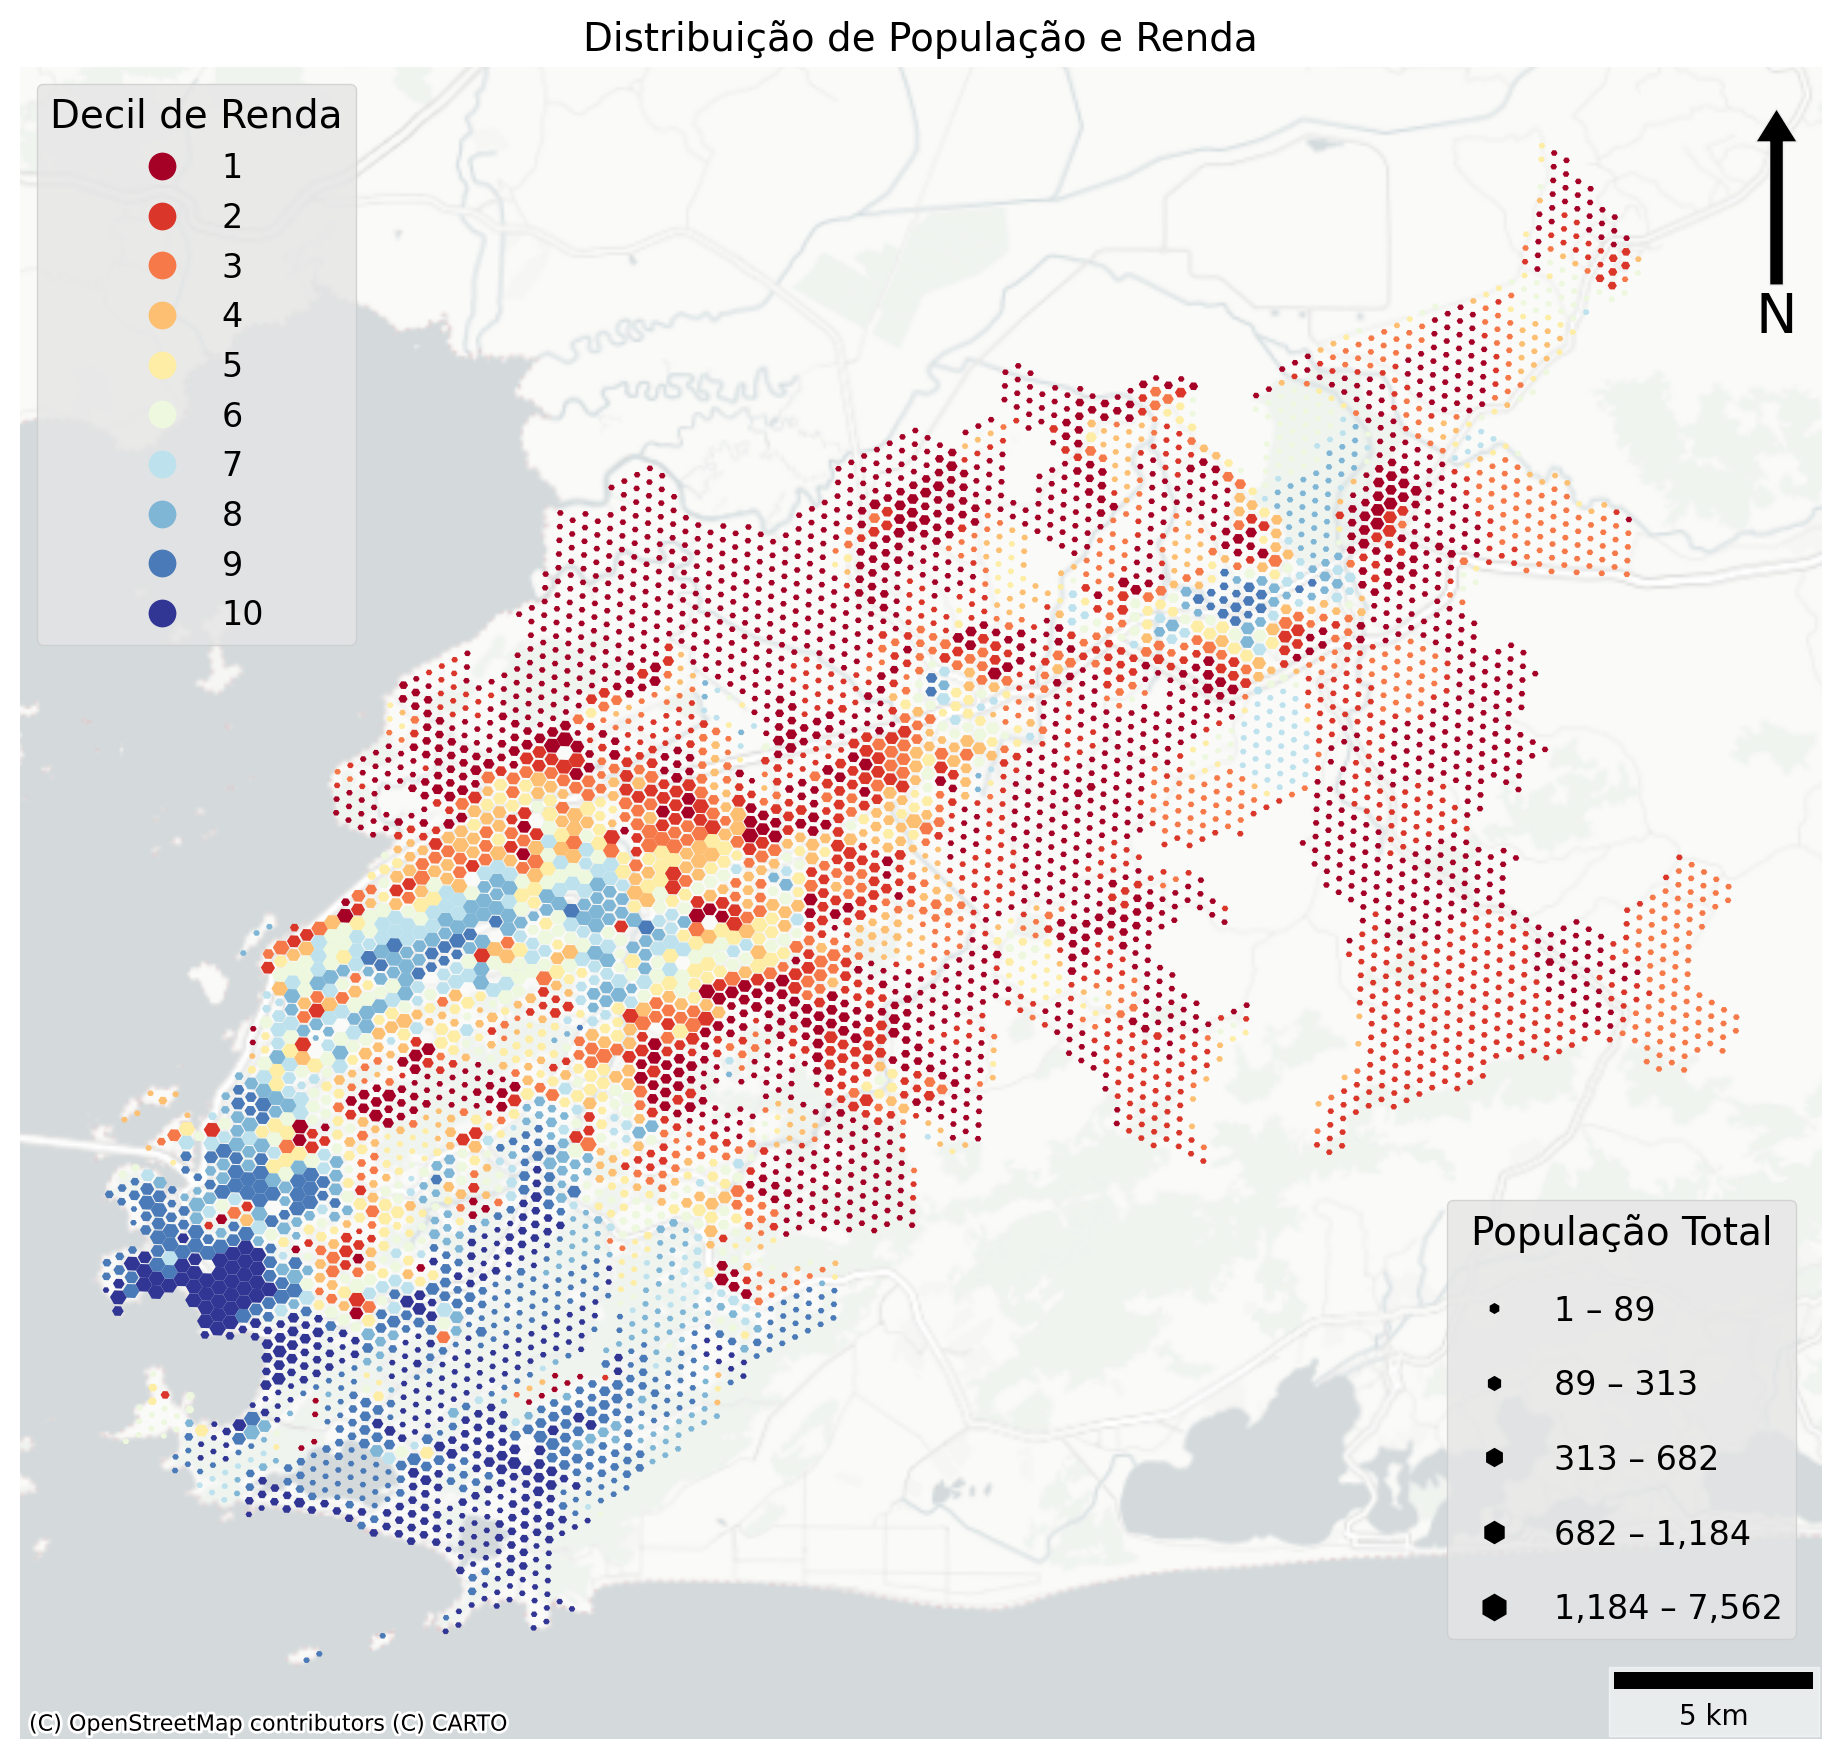

In [50]:
plot_socioeconomic_data(
    hexagons=hex_with_data,
    income_col='rendimento_medio',
    population_column="habitantes",
    population_scheme="JenksCaspall",
    cmap="RdYlBu",
)



O mapa acima mostra a distribuição dos domicílios nos municípios de Niterói, São Gonçalo e Itaboraí. Uma coisa que talvez seja perceptível é que, na criação da escala de cores do mapa, há algumas pequenas regiões com cores muito intensas, enquanto a maior parte parece homogênea.

Isso acontece porquê ao representar dados como a quantidade de domicílios por bairro em uma cidade, é comum encontrar distribuições muito assimétricas — ou seja, a maior parte dos bairros tem poucos domicílios, enquanto poucos bairros concentram números muito altos. Assim, se utilizarmos uma escala uniforme, como de 0 a 3000 domicílios, corremos o risco de comprometer a leitura do mapa.

Nesse tipo de situação, a maioria dos bairros ficará representada com cores muito semelhantes, próximas ao início da escala, e apenas os bairros com maior número de domicílios se destacarão visualmente. Isso esconde padrões importantes e dificulta a análise espacial, já que pequenas variações entre os bairros mais comuns passam despercebidas.

Para tornar o mapa mais informativo, é recomendável utilizar métodos de classificação que redistribuam melhor os valores, como a divisão por quantis ou o método de Jenks, ou até mesmo aplicar transformações nos dados (como logaritmos). Assim, é possível valorizar visualmente as diferenças reais entre os bairros, mesmo que os valores absolutos estejam concentrados em uma faixa pequena da distribuição.

# Exercício: Mapas Coropléticos

Objetivo: Compreender os princípios básicos do mapeamento coroplético e aplicar técnicas de classificação e escolha de cores para representar dados espaciais.

Contexto:

Mapas coropléticos são representações cartográficas que utilizam variações de cor para mostrar valores estatísticos agregados por regiões (como estados, municípios ou bairros). Cada região é associada a um valor e preenchida com uma cor que corresponde à sua classe de valor. Embora hoje seja possível criar mapas sem classificação (unclassed), a abordagem com classes (classed) continua sendo valiosa por facilitar a interpretação visual dos dados.

Três decisões fundamentais no mapeamento coroplético:
- Número de classes: Definir em quantos grupos os valores serão divididos.
- Método de classificação: Escolher o algoritmo para agrupar os dados (ex: quantis, intervalos iguais, Jenks).
- Escolha das cores: Aplicar uma paleta que represente adequadamente as diferenças entre os grupos.

Você deve explorar esses conceitos e, para isso, irá utilizar bibliotecas Python como geopandas e [pacotes do conjunto de bibliotecas PySAL](https://pysal.org/). Acompanhe o capítulo Choropleth Mapping do livro [Geographic Data Science with Python](https://geographicdata.science/book/notebooks/05_choropleth.html) e reproduza o exercício prático lá contido com os municípios acima. Documente o passo a passo e discuta e analise seus achados.